In [1]:
import os
import pandas as pd
import geopandas as gpd
from blocksnet.models import City
from blocksnet.method import Provision

local_crs = 32636
example_data_path = "./data"

city_model = City.from_pickle(os.path.join(example_data_path, 'city_model.pickle'))
prov = Provision(city_model=city_model)

/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_services = {
    'schools': {250: 1.2, 300: 1.1, 600: 1.3, 800: 1.5, 1100: 1.8},
    'kindergartens': {180: 0.72, 250: 1.44, 280: 1.1},
    'recreational_areas': {100:0.1,500:0.5,1000:1.0,3000:3.0,5000:5.0,10000:10.0,15000:15.0},
    'pharmacies':{1000:0.005, 500:0.0025,1000:0.0050,1500:0.0075},
    'hospitals':{60000:1.5,180000:4.5,272000:6.8,360000:9,600000:15},
    'policlinics':{9615:0.3,19230:0.6,28846:0.8,32692:0.9},
}

scenario = ['hospitals', 'policlinics', 'pharmacies']
weights = None
if not weights:
    weights = [round(1/len(scenario), 2) for i in range(len(scenario))]

scenario = dict(zip(scenario, weights))

In [3]:
gdf, total = prov.calculate_scenario(scenario)
print(total)

0.2665891777244658


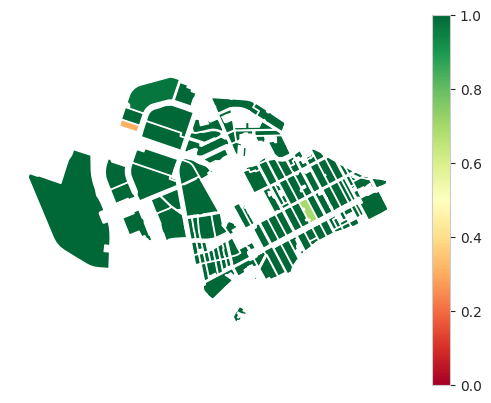

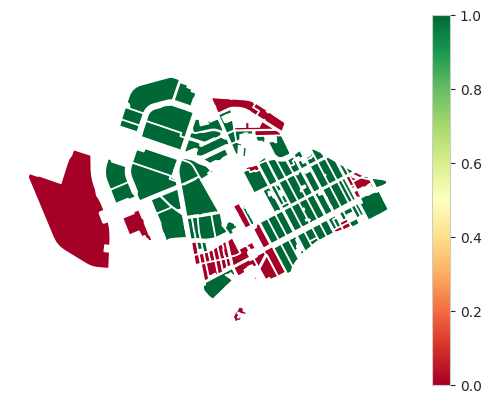

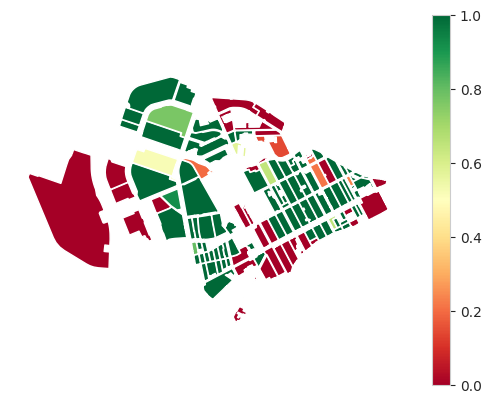

In [4]:
for k,v in gdf.items():
    prov.plot(v)

In [5]:
from blocksnet.method.genetic.genetic import Genetic
gen = Genetic(city_model=city_model, SCENARIO=scenario)

In [8]:
%%time
res = gen.calculate(all_services, 2, selected_blocks=[82,83,84])

/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/pygad/pygad.py:764: UserWarning: The percentage of genes to mutate (10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate ({mutation_percent_genes[idx]}) resutled in selecting ({mutation_num_genes[idx]}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


In [1]:
res

NameError: name 'res' is not defined

In [21]:
update_df = pd.DataFrame.from_dict(res, orient='index')
gdf, total = prov.calculate_scenario(scenario, update_df)
print(total)

0.21276429868211524


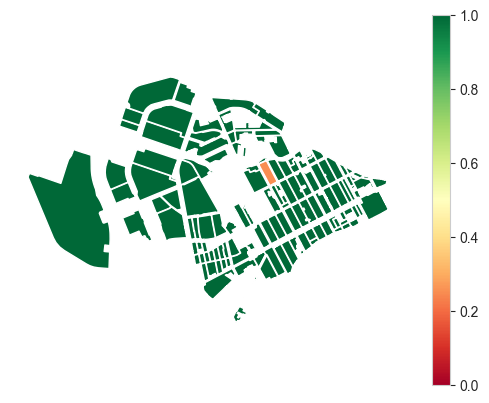

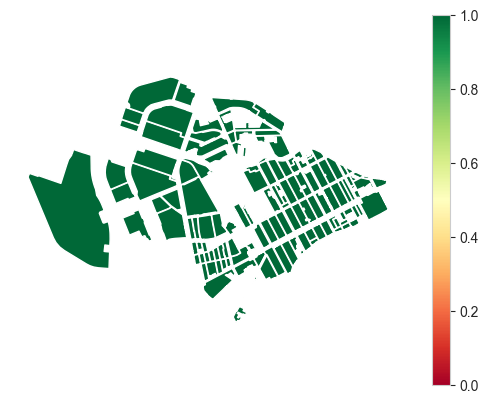

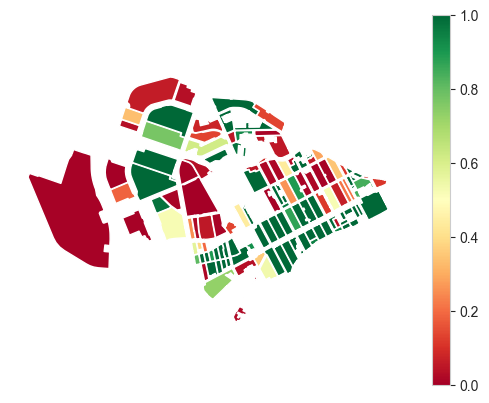

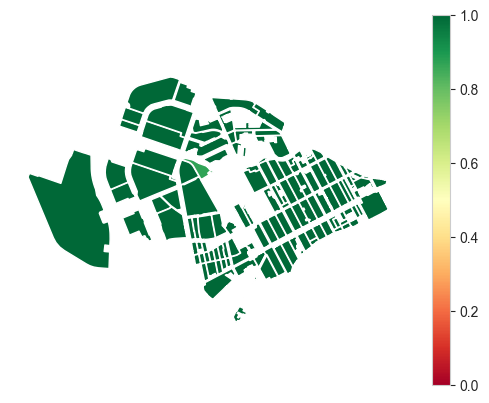

In [22]:
for k,v in gdf.items():
    prov.plot(v)